# DSI Capstone Presentation

Quick Links:
- [Problem Statement and Background](#Problem-statement)
- [Imports and Data](#Imports-and-Data)
- [Data Visualizations and EDA](#Data-Visualizations-and-EDA)
- [Feature Selection and Pre-processing](#Feature-selection-and-preprocessing)
- [Baseline Model: Linear Regression with LASSO](#Linear_regression)
- [LASSO Regression-Polynomial Feature Transformation](#LASSO_regression)
- [Elastic Net Regression](#Enet)
- [OLS Regression](#OLS_Regression)
- [SVM](#SVM)
- [Random Forest Regressor](#Random_Forest_Regressor)
- [Conclusions and Future Research](#Conclusions)
- [Sources](#sources)

<a id='Problem-statement'></a>
## Problem statement: Can the spread of Zika virus be accurately predicted with features such as weather data, human population density, and mosquito data?

    -> What is your goal?

To accurately predict the number of Zika cases (by state) for the 2015-2016 outbreak.

    -> What are your metrics?

Number of cases per state during a given time period 

    -> What were your findings?

Given the data, I was able to narrow in on microcephaly cases (caused by the Zika virus) in Brazil during the outbreak.

    -> What risks/limitations/assumptions affect these findings?
    
The assumption that the microcephaly cases in the data set are linked to zika. Also, that all cases were reported and/or entered in the data set.

A major limitation is the collection of mosquito data:  *"Knowledge of the contemporary distribution of their shared vectors, Aedes aegypti and Aedes albopictus remains incomplete and is complicated by an ongoing range expansion fuelled by increased global trade and travel."* (https://elifesciences.org/articles/08347)

Since mosquito data was missing, I incorporated socioeconomic and population data into my model:

- The Human Development Index per State:  
A composite statistic of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of development.

 - Gross Domestic Product per state

 - State population density

 - GDP per capita
    
 - Weather data (shifted back 30 days due to the mosquito life cycle)

## The zika virus has cost Latin America an estimated 18 Billion USD in social and economic losses-- and the costs are still mounting today.
(http://www.undp.org/content/undp/en/home/presscenter/pressreleases/2017/04/06/social-and-economic-costs-of-zika-can-reach-up-to-us-18-billion-in-latin-america-and-the-caribbean.html)

### However, if the factors that influence an outbreak, especially vector borne viral outbreaks, are better understood, more lives can be saved and costs can be reduced

Some background on the Zika virus:

- First isolated from Zika forest in Uganda in 1947. Originated in Asia. Arrived in Latin America in 2007, resulting in the outbreak in 2015-2016. 

- Analysis reveals that contemporary epidemic strains have accumulated multiple substitutions (mutations) from their Asian ancestor. Scientists have linked these mutations to the microcephaly cases during the outbreak.

- Microcephaly is a birth defect where a baby's head is smaller than other infants of the same age and sex. Developmental delays of the brain can also be present; and microcephaly can be fatal in some cases (as seen in my data set). 

## Imports and Original Dataset (Cleaned)
<a id='Imports-and-Data'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, Imputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

% matplotlib inline

In [2]:
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

## Visualizing the Zika Outbreak Beyond Brazil
<a id='Data-Visualizations-and-EDA'></a>

In [3]:
zika = pd.read_csv('all_countries_data.csv', encoding='latin-1', index_col=[0] )

C:\Users\MissFlave\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (1,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
zika.head()

,GDP_USD_bill,HDI,accent_city,city_region,code,country,data_field,lat,lng,location_type,pop,pop_density,region,report_date,value
0,161.0,0.837,NaN,Buenos_Aires,AR,Argentina,cumulative_confirmed_local_cases,NaN,NaN,province,"15,594,428",50.7,NaN,2016-03-19,0.0
1,161.0,0.837,NaN,Buenos_Aires,AR,Argentina,cumulative_confirmed_imported_cases,NaN,NaN,province,"15,594,428",50.7,NaN,2016-03-19,2.0
4,2.331,0.844,Catamarca,Catamarca,AR,Argentina,cumulative_confirmed_local_cases,-28.469574,-65.785239,province,"367,820",3.6,2.0,2016-03-19,0.0
5,2.331,0.844,Catamarca,Catamarca,AR,Argentina,cumulative_confirmed_imported_cases,-28.469574,-65.785239,province,"367,820",3.6,2.0,2016-03-19,0.0
6,2.12,0.816,NaN,Chaco,AR,Argentina,cumulative_confirmed_local_cases,NaN,NaN,province,"1,053,466",10.6,NaN,2016-03-19,0.0


In [5]:
zika.dropna(subset=['lat'], how='all', inplace = True)

In [6]:
zika.isnull().sum()

GDP_USD_bill     43963
HDI              43963
accent_city       1243
city_region          0
code                 0
country              0
data_field           0
lat                  0
lng                  0
location_type        0
pop                  0
pop_density      43963
region            1243
report_date          0
value                0
dtype: int64

In [7]:
zika['pos'] = list(zip(zika.lng, zika.lat))

In [8]:
zika =  zika[zika.country != 'Colombia']

In [9]:
zika.head()

,GDP_USD_bill,HDI,accent_city,city_region,code,country,data_field,lat,lng,location_type,pop,pop_density,region,report_date,value,pos
4,2.331,0.844,Catamarca,Catamarca,AR,Argentina,cumulative_confirmed_local_cases,-28.469574,-65.785239,province,"367,820",3.6,2.0,2016-03-19,0.0,"(-65.785239, -28.469574)"
5,2.331,0.844,Catamarca,Catamarca,AR,Argentina,cumulative_confirmed_imported_cases,-28.469574,-65.785239,province,"367,820",3.6,2.0,2016-03-19,0.0,"(-65.785239, -28.469574)"
10,33.239000000000004,0.846,Cordoba,Cordoba,AR,Argentina,cumulative_confirmed_local_cases,-31.413496,-64.181052,province,"3,304,825",20.0,5.0,2016-03-19,1.0,"(-64.181052, -31.413496)"
11,33.239000000000004,0.846,Cordoba,Cordoba,AR,Argentina,cumulative_confirmed_imported_cases,-31.413496,-64.181052,province,"3,304,825",20.0,5.0,2016-03-19,1.0,"(-64.181052, -31.413496)"
12,4.053,0.825,Corrientes,Corrientes,AR,Argentina,cumulative_confirmed_local_cases,-27.480596,-58.834099,province,"993,338",11.3,6.0,2016-03-19,0.0,"(-58.834099, -27.480596)"


In [10]:
zika.shape

(2666, 16)

In [11]:
zika.country.unique()

array(['Argentina', 'Brazil', 'Mexico', 'Dominican_Republic', 'Guatemala',
       'Nicaragua', 'Panama'], dtype=object)

In [12]:
colour_set = ['#f9ebea','#d5d8dc','#c39bd3','#BA4A00','#17A589','#1E8449','#e2df5d','#2E4053','#F1c40F','#A9DFBF','#F0B27A']

In [128]:
def outbreak_map():
    fig, ax = plt.subplots(figsize=(10,20))
    m = Basemap(resolution='c', # c, l, i, h, f or None
            projection='merc',
            lat_0=75, lon_0=18,
            llcrnrlon=-118.8, llcrnrlat= -56.9, urcrnrlon=-32.3, urcrnrlat=33.8)
    m.drawmapboundary(fill_color='blue')
    m.fillcontinents(color='white',lake_color='#46bcec')
    m.drawcoastlines()
    m.ax = ax
    m.fillcontinents()
    for i, r in zika.iterrows():
        x,y = r['pos']
        size = (r['value']/10)
        m.plot(x, y, marker = 'o', c='red', markersize=1*size, alpha=0.5, latlon=True)
    plt.title("Zika in Argentina, Brazil, Mexico, Dominican Republic, Guatemala, Nicaragua, and Panama")
    return fig, m

C:\Users\MissFlave\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\MissFlave\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1710: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
C:\Users\MissFlave\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\MissFlave\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


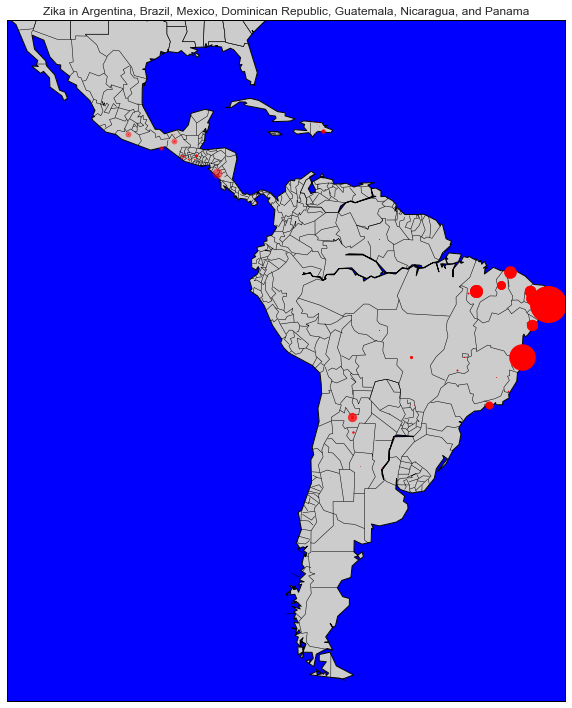

In [129]:
fig, m = outbreak_map()
m.drawcountries()
_ = m.drawstates()

# I had to eliminate Colomiba from my data set because the cases were recorded in a cumulative fashion

## Analyzing Microcephaly Cases during the Zika Outbreak of 2015-2016

In [13]:
brazil = pd.read_csv('brazil_model_data_shift_30.csv', encoding='latin-1', index_col=[0] )

In [14]:
brazil = brazil.set_index(pd.DatetimeIndex(brazil['report_date']))
del brazil['report_date']

In [15]:
brazil = brazil.rename(columns={'city_region': 'state_region'})

In [16]:
brazil = pd.get_dummies(brazil, columns=['data_field'])

In [17]:
brazil.head()

,location_type,value,country,state_region,code,accent_city,region,pop,lat_x,lng,...,lat_y,tmpf,dwpf,relh,drct,sknt,p01i,alti,data_field_microcephaly_confirmed,data_field_microcephaly_fatal_confirmed
report_date,,,,,,,,,,,,,,,,,,,,,
2016-02-13,state,0.0,Brazil,Acre,BR,NaN,NaN,790101,-9.0,-68.669979,...,-8.924227,79.454545,74.259091,85.238636,170.909091,3.045455,0.0,29.859545,1,0
2016-02-13,state,25.0,Brazil,Alagoas,BR,NaN,NaN,3321730,-9.0,-35.839968,...,-9.488640,83.000000,73.520000,76.589333,80.000000,6.933333,0.0,29.893667,1,0
2016-02-13,state,107.0,Brazil,Bahia,BR,NaN,NaN,15126371,-16.0,-39.029980,...,-13.530665,82.541732,71.514961,70.642205,96.850394,6.976378,0.0,29.911417,1,0
2016-02-13,state,24.0,Brazil,Ceara,BR,NaN,NaN,8842791,-3.0,-40.850024,...,-7.219000,84.863158,72.168421,66.501579,69.473684,1.263158,0.0,29.987368,1,0
2016-02-13,state,0.0,Brazil,Distrito_Federal,BR,NaN,NaN,2852372,-16.0,-47.916052,...,-15.866700,73.472000,64.904000,75.413600,213.600000,4.520000,0.0,30.020400,1,0


In [18]:
brazil['incidence'] = brazil['value']/ brazil['pop']

In [19]:
brazil['GDP_per_capita'] = (brazil['GDP_USD_bill']*1000000000)/brazil['pop']

In [20]:
brazil['pos'] = list(zip(brazil.lon, brazil.lat_y))

In [21]:
brazil.head()

,location_type,value,country,state_region,code,accent_city,region,pop,lat_x,lng,...,relh,drct,sknt,p01i,alti,data_field_microcephaly_confirmed,data_field_microcephaly_fatal_confirmed,incidence,GDP_per_capita,pos
report_date,,,,,,,,,,,,,,,,,,,,,
2016-02-13,state,0.0,Brazil,Acre,BR,NaN,NaN,790101,-9.0,-68.669979,...,85.238636,170.909091,3.045455,0.0,29.859545,1,0,0.000000,5224.648494,"(-70.0121363636, -8.92422727273)"
2016-02-13,state,25.0,Brazil,Alagoas,BR,NaN,NaN,3321730,-9.0,-35.839968,...,76.589333,80.000000,6.933333,0.0,29.893667,1,0,0.000008,4229.723668,"(-36.2767, -9.48864)"
2016-02-13,state,107.0,Brazil,Bahia,BR,NaN,NaN,15126371,-16.0,-39.029980,...,70.642205,96.850394,6.976378,0.0,29.911417,1,0,0.000007,4908.712076,"(-39.4747181102, -13.5306645669)"
2016-02-13,state,24.0,Brazil,Ceara,BR,NaN,NaN,8842791,-3.0,-40.850024,...,66.501579,69.473684,1.263158,0.0,29.987368,1,0,0.000003,4476.301656,"(-39.2701, -7.219)"
2016-02-13,state,0.0,Brazil,Distrito_Federal,BR,NaN,NaN,2852372,-16.0,-47.916052,...,75.413600,213.600000,4.520000,0.0,30.020400,1,0,0.000000,22906.549356,"(-47.9333, -15.8667)"


In [22]:
brazil.describe()
## Weather Variables needed for the mosquito outbreak- Taken from Mario's code:
# https://github.com/majacaci00/zika_in_brazil/blob/master/Brazil_weather_master.ipynb
# station,valid, lon, lat, 
# tmpf: Air Temperature in Fahrenheit, typically @ 2 meters
# dwpf: Dew Point Temperature in Fahrenheit, typically @ 2 meters
# dew point is a true measurement of the atmospheric moisture
# relh: Relative Humidity in %
# drct: Wind Direction in degrees from north
# sknt: sknt: Wind Speed in knots
# p01i: One hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset. 
# The precipitation data is not what I expected (all zeros)
# alti: Pressure altimeter in inches

,value,region,pop,lat_x,lng,pop_density,GDP_USD_bill,HDI,lon,lat_y,...,dwpf,relh,drct,sknt,p01i,alti,data_field_microcephaly_confirmed,data_field_microcephaly_fatal_confirmed,incidence,GDP_per_capita
count,978.000000,185.000000,9.780000e+02,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,...,978.000000,978.000000,978.000000,978.000000,978.0,978.000000,978.000000,978.000000,9.780000e+02,978.000000
mean,26.342536,22.686486,7.973359e+06,-12.971697,-47.084060,75.917587,71.655858,0.737282,-45.865320,-10.965880,...,69.028480,75.307605,137.502426,5.930764,0.0,29.977943,0.570552,0.429448,4.933747e-06,7624.004478
std,60.151602,9.641908,9.142552e+06,8.593913,8.753858,113.655731,118.572193,0.046876,9.604338,7.488528,...,7.359374,9.643296,43.055919,2.174532,0.0,0.110504,0.495251,0.495251,9.272814e-06,4150.896451
min,0.000000,3.000000,4.969360e+05,-30.880041,-68.669979,2.200000,3.138000,0.667000,-70.117476,-26.880000,...,28.580000,46.557500,14.583333,0.434783,0.0,29.746316,0.000000,0.000000,0.000000e+00,3471.084899
25%,0.000000,15.000000,2.852372e+06,-19.000000,-54.269980,7.400000,14.050000,0.703000,-50.806082,-16.231918,...,66.101099,70.689600,106.177885,4.333333,0.0,29.893872,0.000000,0.000000,0.000000e+00,4908.712076
50%,3.000000,27.000000,3.943885e+06,-11.269611,-46.527817,35.400000,36.474000,0.732000,-44.961172,-8.981858,...,71.214939,75.555833,136.363636,5.829710,0.0,29.955000,1.000000,0.000000,6.202787e-07,5856.848912
75%,13.000000,29.000000,9.277727e+06,-6.000000,-39.029980,84.300000,74.251000,0.771000,-37.070300,-5.713425,...,74.071556,81.019008,165.263158,7.373355,0.0,30.040714,1.000000,1.000000,3.793451e-06,10095.346142
max,367.000000,31.000000,4.403530e+07,2.000000,-35.020044,493.500000,587.855000,0.839000,-34.850000,3.833300,...,84.200000,100.000000,304.615385,12.833333,0.0,30.312273,1.000000,1.000000,5.136121e-05,22906.549356


In [23]:
brazil.columns

Index(['location_type', 'value', 'country', 'state_region', 'code',
       'accent_city', 'region', 'pop', 'lat_x', 'lng', 'pop_density',
       'GDP_USD_bill', 'HDI', 'lon', 'lat_y', 'tmpf', 'dwpf', 'relh', 'drct',
       'sknt', 'p01i', 'alti', 'data_field_microcephaly_confirmed',
       'data_field_microcephaly_fatal_confirmed', 'incidence',
       'GDP_per_capita', 'pos'],
      dtype='object')

In [24]:
brazil.dtypes

location_type                               object
value                                      float64
country                                     object
state_region                                object
code                                        object
accent_city                                 object
region                                     float64
pop                                          int64
lat_x                                      float64
lng                                        float64
pop_density                                float64
GDP_USD_bill                               float64
HDI                                        float64
lon                                        float64
lat_y                                      float64
tmpf                                       float64
dwpf                                       float64
relh                                       float64
drct                                       float64
sknt                           

In [25]:
brazil.value.sum()

25763.0

## Confirmed Microcephaly Case Data Visualizations

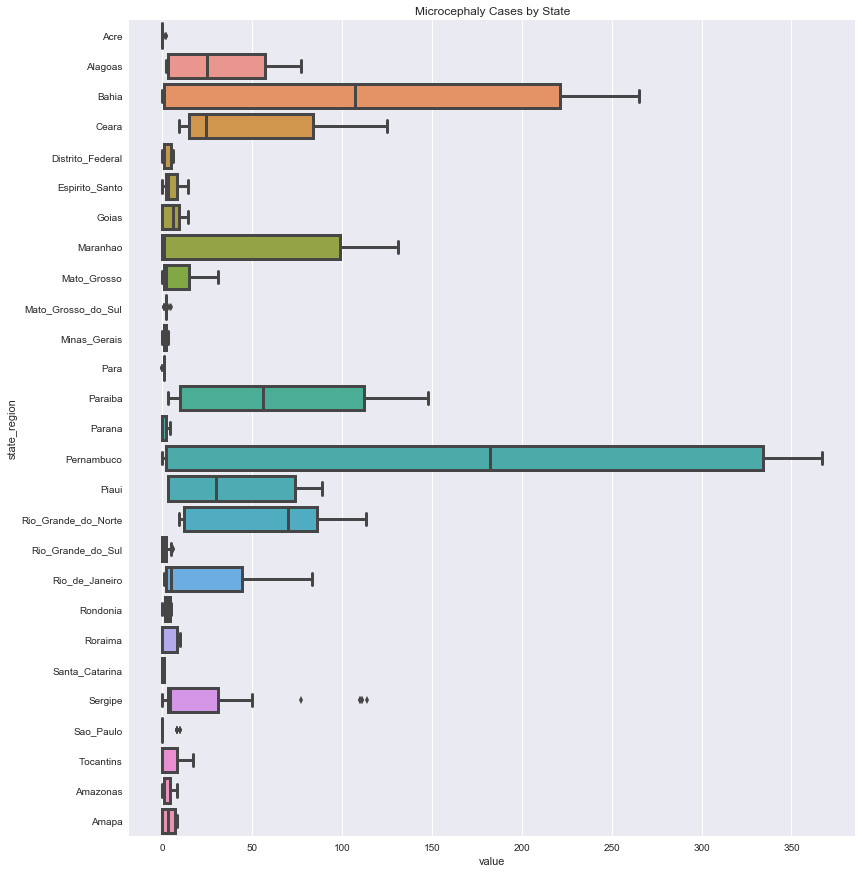

In [47]:
sns.set(rc={'figure.figsize':(13,15)})
sns.boxplot( x=brazil["value"], y=brazil["state_region"], linewidth=3).set_title('Microcephaly Cases by State');
# Several states are hit extremely hard, while others are not 

In [330]:
# part of the code and idea for this visualization came from Mario's github: 
# https://github.com/majacaci00/zika_in_brazil

def plot_num_ts(num, seq):
    
    num = num.sort_index(ascending = False)
    num = num.resample(seq).sum()
    mask = np.isfinite(num['value'])
    fig = plt.figure(figsize=(12,5))
    ax = fig.gca()
    ax.plot(num['value'][mask], c='y', lw=2, linestyle='solid', marker='o',
                markerfacecolor='darkblue', markersize=10,
            label="Brazil - number of microcephaly confirmed cases (2016) per %s"%seq)
    ax.set_facecolor('green')
    legend = plt.legend(loc='best', fontsize='large')
    plt.setp(legend.get_texts(), color='y')   
    plt.xlabel('\nTime progression in %s'%seq)
    plt.ylabel("Microcephaly confirmed cases\n")
    plt.show()

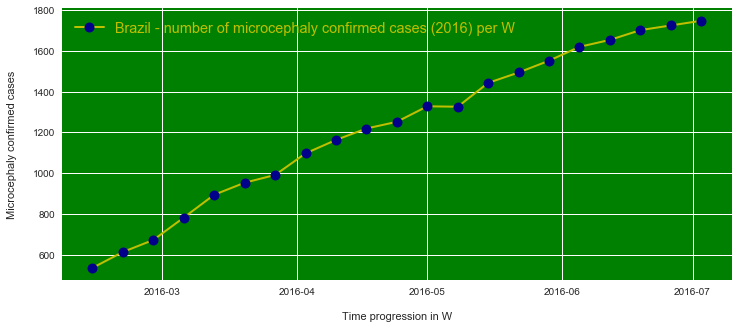

In [331]:
plot_num_ts(brazil, 'W')

## Confirmed Microcephaly Cases by State

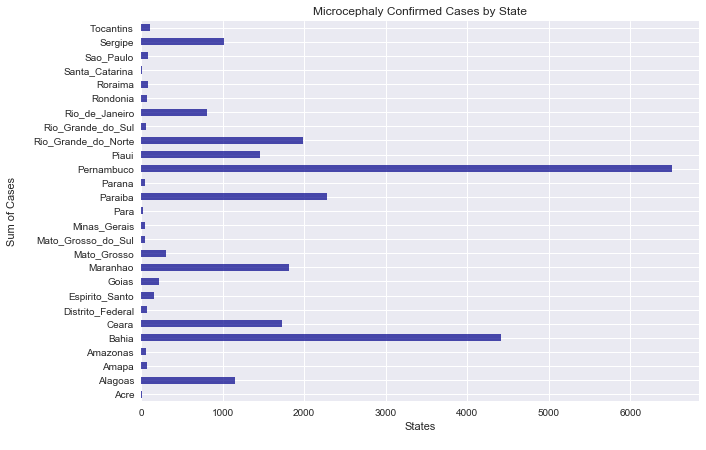

In [56]:

confirmed_group= brazil[brazil['data_field_microcephaly_confirmed'] == 1].groupby(['state_region'])['value'].sum()

# category_group_1
# print "+++++++++"
fig = plt.figure(figsize=(10,7))
braz_microc_conf_1 = confirmed_group.plot(kind='barh', color='darkblue', alpha=0.7, 
                                           title= "Microcephaly Confirmed Cases by State")
braz_microc_conf_1.set_xlabel("States\n")
braz_microc_conf_1.set_ylabel("Sum of Cases\n");


## Fatal Confirmed Cases

Text(28.8,0.5,'Sum of Cases\n')

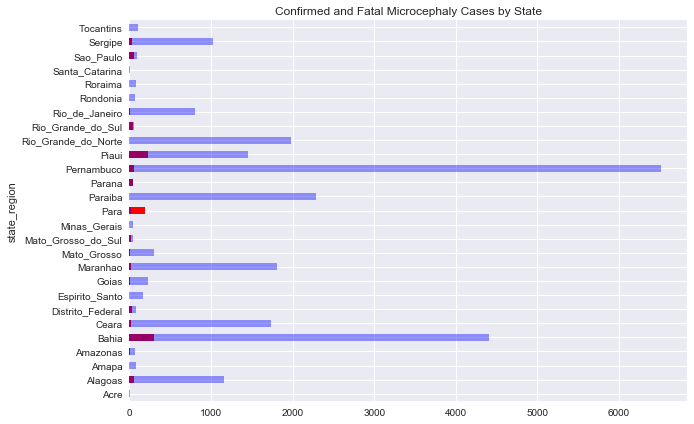

In [69]:
fatal_group= brazil[brazil['data_field_microcephaly_fatal_confirmed'] == 1].groupby(['state_region'])['value'].sum()

# print category_group_2
# print "++++++++"

fig = plt.figure(figsize=(10,7))
fatal_group.plot(kind='barh', color='red', alpha=1,
                                      title= "Microcephaly Confirmed Fatal Cases by State")
confirmed_group.plot(kind='barh', color='blue', alpha=.4, 
                                           title= "Confirmed and Fatal Microcephaly Cases by State")
braz_microc_conf_2.set_xlabel("States\n")
braz_microc_conf_2.set_ylabel("Sum of Cases\n")


Why are there so many fatalities in the state of Para? This is any interesting question for further research.

## Geospatial Analysis with Basemap

In [132]:
region_set = set(brazil['state_region']) # Creates a list of all the unique regions
colour_set = ['#f9ebea','#d5d8dc','#c39bd3','#BA4A00','#17A589','#1E8449','#e2df5d','#2E4053','#F1c40F','#A9DFBF',
              '#F0B27A', 'red', 'blue', 'green', 'purple', 'orange', 'black', 'white', 'darkblue', 'lightgreen',
             'yellow', 'pink', 'darkgreen', 'lightblue', 'gray', 'darkred', '#8c9f8d'] # A list of random colour codes
region_colour_dict = dict(zip(region_set, colour_set)) # Creates a dictionary so each region has a colour code

In [135]:
def make_map():
    fig, ax = plt.subplots(figsize=(10,20))
    m = Basemap(resolution='c', # c, l, i, h, f or None
            projection='merc',
            lat_0=61, lon_0=25,
            llcrnrlon=-84.5, llcrnrlat= -56.1, urcrnrlon=-28.7, urcrnrlat=16.8)
    m.drawmapboundary(fill_color='blue')
    m.fillcontinents(color='white',lake_color='#46bcec')
    m.drawcoastlines()
    m.ax = ax
    m.fillcontinents()
    for i, r in brazil.iterrows():
        x,y = r['pos']
        size = (r['value']/3)
        m.plot(x, y, marker = 'o', c=region_colour_dict[r['state_region']], markersize=1*size, alpha=0.2, latlon=True)
    plt.title("Microcephaly in Brazil- Color Coded by State")
    return fig, m

C:\Users\MissFlave\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\MissFlave\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1710: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
C:\Users\MissFlave\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\MissFlave\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


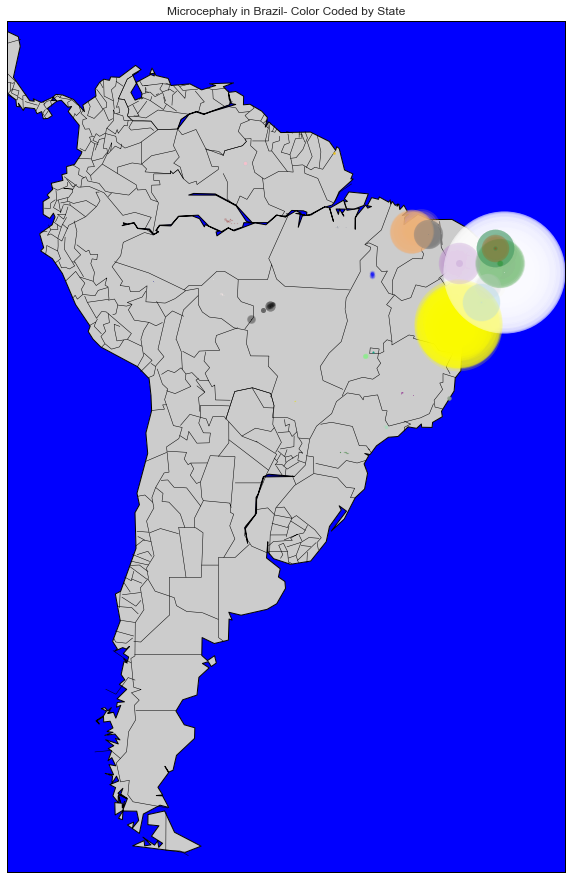

In [136]:
fig, m = make_map()
m.drawcountries()
_ = m.drawstates()

<a id='Feature-selection-and-preprocessing'></a>
## Selecting Features and Splitting into Training/Testing Data

In [26]:
X = brazil[['pop_density', 'pop', 'GDP_USD_bill', 'HDI', 'lon', 'lat_y', 'tmpf', 'dwpf',
       'relh', 'drct', 'sknt', 'alti', 'GDP_per_capita', 'data_field_microcephaly_fatal_confirmed']]
y = brazil['value']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

<a id='Linear_regression'></a>
### Baseline Model: A linear regression, with Lasso regularization, tuned with GridSearchCV
This is my baseline model, despite my dependent variable being non-linear. 

In [73]:
ss = StandardScaler()
lasso = Lasso()

In [74]:
pipe = Pipeline([
    ('ss', ss),
    ('lasso', lasso)
])

params = {
    'lasso__alpha': np.arange(.05, .5, 1)
}
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.354632141243


{'lasso__alpha': 0.050000000000000003}

In [75]:
gs.score(X_test, y_test)

0.3700579969555412

<a id='LASSO_regression'></a>
## LASSO Regression with Polynomial Transformation
### This is my runner-up for best model in terms of lowest RMSE and highest R squared
Intuitively, this model performs better than the baseline because my dependent variable (y = number of zika cases) is non-linear. 

In [63]:
from sklearn.pipeline import make_pipeline

In [64]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=100
# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 4
#
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, 
#run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(tol=0.1,eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=3))
    model.fit(X_train,y_train)

C:\Users\MissFlave\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\MissFlave\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [65]:
test_pred = np.array(model.predict(X_test))
RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
test_score = model.score(X_test,y_test)

In [66]:
test_pred.mean()
# The mean number of cases in the data set is 26.3 (this is good!)

28.418297586643153

In [67]:
print(RMSE)

#This is the 2nd best RMSE of all of my models- It's slightly higher than the RF Regressor 

436.583767117


In [68]:
print(test_score)
# This is the 2nd highest R squared- Random Forest Regressor had the best score (>0.80)

0.712072977151


<a id='Enet'></a>
## Enet (Elastic-Net) Regression
Enet performed about the same as LASSO without the transformed features. This is to be expected because my data set does not have a large number of weak predictors-- it has a small number of strong ones.

In [78]:
ss.fit(X)
X_scaled = ss.transform(X)

In [79]:
enet_alphas = np.arange(.00001,.01, .1)
coefs = []
for alpha in enet_alphas:
    model = ElasticNet(alpha=alpha, l1_ratio=.1)
    model.fit(X_scaled, y)
    coefs.append(model.coef_)

C:\Users\MissFlave\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [80]:
best_enet = ElasticNetCV(l1_ratio=[.00001, .01, .1, .2, .3, .4, .5], alphas=enet_alphas)
best_enet.fit(X_scaled, y)
print("best alpha", best_enet.alpha_)
print("best l1 ratio", best_enet.l1_ratio_)
best_enet.score(X_scaled, y)

best alpha 1e-05
best l1 ratio 1e-05


C:\Users\MissFlave\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\MissFlave\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.38272380654398441

In [81]:
ENreg = ElasticNet(alpha=0.00001, l1_ratio=0.00001, normalize=False)

ENreg.fit(X_train_scaled, y_train)

pred_EN = ENreg.predict(X_test)

C:\Users\MissFlave\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Enet dropped 0 of 14 features.


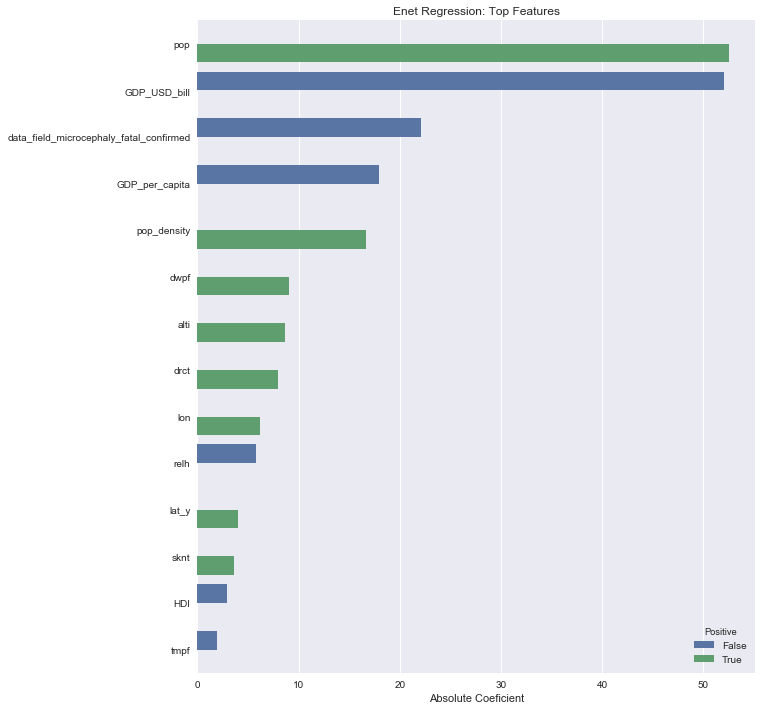

In [82]:
coefs = pd.DataFrame({'coefs':ENreg.coef_,'Positive':ENreg.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('Enet dropped {} of {} features.'.format(
    sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(50)
plt.figure(figsize=(10,12))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('Enet Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

<a id='OLS_Regression'></a>
## OLS Regression

OLS gave decent results, similar to the baseline, with an adjusted R-squared of ~0.46

In [83]:
import statsmodels.api as sm

C:\Users\MissFlave\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [84]:
smfit = sm.OLS(y_train, X_train).fit()
smfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     47.15
Date:                Mon, 09 Apr 2018   Prob (F-statistic):           7.90e-92
Time:                        22:46:18   Log-Likelihood:                -3829.3
No. Observations:                 733   AIC:                             7687.
Df Residuals:                     719   BIC:                             7751.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
pop_density                                 0.1424      0.037      3.803      0.000       0.069       0.216
pop                                      5.778e-06   8.55e-07      6.754      0.000     4.1e-06    7.46e-06
GDP_USD_bill                               -0.4417      0.067     -6.594      0.000      -0.573      -0.310
HDI                                       -59.3593    109.917     -0.540      0.589    -275.156     156.437
lon                                         0.7889      0.270      2.923      0.004       0.259       1.319
lat_y                                       0.4088      0.347      1.180      0.239      -0.272       1.089
tmpf                                       -1.9615      2.739     -0.716      0.474      -7.340       3.417
dwpf                                        1.9759      2.799      0.706      0.480      -3.519       7.471
relh                                       -1.1707      1.231     -0.951      0.342      -3.588       1.247
drct                                        0.1653      0.046      3.620      0.000       0.076       0.255
sknt                                        1.1149      0.940      1.186      0.236      -0.731       2.961
alti                                        7.0082      4.474      1.567      0.118      -1.775      15.791
GDP_per_capita                             -0.0039      0.002     -2.312      0.021      -0.007      -0.001
data_field_microcephaly_fatal_confirmed   -43.9129      3.410    -12.876      0.000     -50.608     -37.217
==============================================================================
Omnibus:                      428.630   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4184.349
Skew:                           2.495   Prob(JB):                         0.00
Kurtosis:                      13.588   Cond. No.                     8.12e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a id='SVM'></a>
## SVM

SVR model did not give good results (negative R squared)

In [85]:
from sklearn import svm
from sklearn.svm import SVR

In [86]:
SVR = svm.SVR()

In [87]:
pipe = Pipeline([
    ('ss', ss),
    ('SVR', SVR)
])

params = {
    'SVR__epsilon': np.arange(0.05, 0.1, 0.2),
    'SVR__C': np.arange(0.1, 0.5,1),
}
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

-0.118637286628


{'SVR__C': 0.10000000000000001, 'SVR__epsilon': 0.050000000000000003}

<a id='Random_Forest_Regressor'></a>
## Random Forest Regressor with CV
I created a baseline random forest regression model, and a model with randomly chosen parameters:

In [54]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [55]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [56]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.6min finished


In [57]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1800}

## Evaluating the RF Models

In [58]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    
    return accuracy

In [59]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 5.6899 degrees.


In [60]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
# The randomly chosen parameters are not much better than the baseline model

Model Performance
Average Error: 5.3884 degrees.


## Random Forest Regressor tuned with Grid Search
This RF model is my best model (lowest RMSE and highest R squared), which makes sense considering my data is non-linear.

In [29]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [30]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train);

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  5.1min finished


In [31]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [61]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 11.1984 degrees.


In [43]:
rf = RandomForestRegressor(bootstrap=True, max_depth= 80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000)

In [85]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [45]:
from sklearn.metrics import r2_score
train_pred = rf.predict(X_train)
r2_score(y_train , train_pred)

0.92860325781946318

In [46]:
y_pred = rf.predict(X_test)

In [50]:
y_pred.mean()
# This is very close to the mean y of the whole data set

26.669408267185556

In [47]:
from sklearn.metrics import mean_squared_error
mse_test = mean_squared_error(y_test, y_pred)
mse_test

478.029473617522

In [48]:
RMSE=np.sqrt(np.sum(np.square(y_pred-y_test)))
RMSE

342.22393404946547

In [49]:
r2_score(y_test , y_pred)

0.82308363086518732

In [86]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [87]:
feature_importances

# The binary column indicating whether the confirmed cases were fatal or not is the most important
# feature. It's also interesting that longitude and the GDP per capita are also important. I assumed
# the weather data would be more important. This makes the case for better weather data collection, and
# implementation as a feature. 

,importance
data_field_microcephaly_fatal_confirmed,0.377658
lon,0.243440
GDP_per_capita,0.139355
pop,0.099497
lat_y,0.038341
tmpf,0.026021
HDI,0.018778
GDP_USD_bill,0.015784
alti,0.013151
pop_density,0.008048


<a id='Conclusions'></a>
# Conclusions and Future Research

- Incorporating better weather data, and future population/socio-economic projections for predicting a future outbreak.


- Incorporting information about interventions and mosquito control efforts on the state and national levels.


- Can I sucessfully build models for other countries? What about other mosquito borne diseases such as dengue, west nile, and chikungunya?


- Using a clustering algorithm to differentiate between fatal and non-fatal microcephaly cases. What factors increase the likelihood of microcephaly being fatal?


- Train a neural network


- Use Bayes Regression for further insights 


- Ensemble models to improve performance. 

# Sources Cited

Carrillo, Mario. Zika in Brazil, (2016), GitHub repository, https://github.com/majacaci00/zika_in_brazil

DistanceLatLong. "List of States in Brazil with Latitude and Longitude". http://www.distancelatlong.com/country/brazil

eLife. "The global distribution of the arbovirus vectors Aedes aegypti and Ae. albopictus"
Moritz UG Kraemer  Is a corresponding author , Marianne E Sinka, Kirsten A Duda, Adrian QN Mylne, Freya M Shearer, Christopher M Barker, Chester G Moore, Roberta G Carvalho, Giovanini E Coelho Wim Van Bortel, Guy Hendrickx, Francis Schaffner, Iqbal RF Elyazar, Hwa-Jen Teng, Oliver J Brady, Jane P Messina, David M Pigott, Thomas W Scott, David L Smith, GR William Wint, Nick Golding, Simon I Hay  Is a corresponding author expand author listsee all
RESEARCH ARTICLE Jun 30, 2015. eLife 2015;4:e08347
https://elifesciences.org/articles/08347

Johns Hopkins University Bloomberg School of Public Health. "Cost of Zika outbreak in the United States could be high: Computer model estimates even a mild epidemic could cost in the hundreds of millions." ScienceDaily. ScienceDaily, 3 May 2017.
https://www.sciencedaily.com/releases/2017/05/170503110759.htm

NASA's Socioeconomic Data and Applications Center (sedac)
A Data Center in NASA's Earth Observing System Data and Information System (EOSDIS) — Hosted by CIESIN at Columbia University
http://sedac.ciesin.columbia.edu/data/sets/browse/2?facets=theme:climate

PNAS. "Spread of Zika virus in the Americas". Qian Zhang, Kaiyuan Sun, Matteo Chinazzi, Ana Pastore y Piontti, Natalie E. Dean, Diana Patricia Rojas, Stefano Merler, Dina Mistry, Piero Poletti, Luca Rossi, Margaret Bray, M. Elizabeth Halloran, Ira M. Longini, Alessandro Vespignani
Proceedings of the National Academy of Sciences May 2017, 114 (22) E4334-E4343; DOI: 10.1073/pnas.1620161114
http://www.pnas.org/content/114/22/E4334

Scientific American. "Scientists Can See Zika Coming by Tracking the Climate."
Umair Irfan, ClimateWire on July 24, 2017.
https://www.scientificamerican.com/article/scientists-can-see-zika-coming-by-tracking-the-climate/

UNDP. "Social and economic costs of Zika can reach up to US$ 18 billion in Latin America and the Caribbean". Apr 6, 2017. http://www.undp.org/content/undp/en/home/presscenter/pressreleases/2017/04/06/social-and-economic-costs-of-zika-can-reach-up-to-us-18-billion-in-latin-america-and-the-caribbean.html

Wikipedia. "List of Brazilian federative units by gross regional product". 
https://en.wikipedia.org/wiki/List_of_Brazilian_federative_units_by_gross_regional_product

Wikipedia. "List of Brazilian federative units by Human Development Index". https://en.wikipedia.org/wiki/List_of_Brazilian_federative_units_by_Human_Development_Index


Wikipedia. "List of Brazilian states by population density". https://en.wikipedia.org/wiki/List_of_Brazilian_states_by_population_density

